In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import warnings
warnings.filterwarnings("ignore")

In [6]:
parent_directory = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))),'data')
atlas_directory = os.path.join(parent_directory,"atlas")
data_final_directory = os.path.join(parent_directory,"data_final")

assert os.path.isdir(parent_directory), f"{parent_directory} does not exist."

# read metadata csv
metadata_csv = pd.read_csv("../../data/data_final/combined_atlas_metadata.csv")

sleep_stages_to_run = ["W","N2","N3","R"]
band_names = ["delta", "theta", "alpha", "beta", "gamma", "broad"]

# load z-score npz files
bp_scores = np.load(os.path.join(data_final_directory,'combined_atlas_bandpower_normative.npz'), allow_pickle=True)
co_scores = np.load(os.path.join(data_final_directory,'combined_atlas_coherence_normative.npz'), allow_pickle=True)
#bool_dict = {np.nan: False, True: True, False: False}

In [7]:
y_train = []
# get indices of patients in metadata_csv with Engel class 1
good_outcome_indices = np.where(metadata_csv["engel"] == 1)[0]
# good outcome rows
good_outcome_rows = metadata_csv.iloc[good_outcome_indices]

In [207]:
# concatenate all scores
bp_scores_all = np.concatenate((bp_scores["W"][:-1], bp_scores["N2"][:-1], bp_scores["N3"][:-1], bp_scores["R"][:-1]))
# set column names
bp_scores_all_df = pd.DataFrame(bp_scores_all, columns=band_names)
metadata_df = pd.DataFrame()

# add outcome column using good outcome indices
metadata_df["good_outcome"] = pd.concat([metadata_csv["engel"] == 1], ignore_index=True)
res_soz = [((row[1]["ch1_resected"] is True) | (row[1]["ch2_resected"] is True)) & ((row[1]["ch1_soz"] is True) | (row[1]["ch2_soz"] is True)) for row in metadata_csv.iterrows()]
metadata_df["res_soz"] = res_soz
metadata_df["normative"] = metadata_csv["normative"]
# initialize type column
metadata_df["type"] = np.nan
# set type column to "normative" if normative is True
metadata_df.loc[metadata_df["normative"] == True, "type"] = "normative"
# set type column to "irritative" if normative is False and res_soz is False
metadata_df.loc[(metadata_df["normative"] == False) & (metadata_df["res_soz"] == False), "type"] = "irritative"
# set type column to "soz" if normative is False and res_soz is True
metadata_df.loc[(metadata_df["normative"] == False) & (metadata_df["res_soz"] == True), "type"] = "soz"

single_stage_metadata_df = metadata_df

# repeat metadata_df by 4
metadata_df = pd.concat([metadata_df]*4, ignore_index=True)

metadata_df["stage"] = np.concatenate((np.repeat("W", bp_scores["W"].shape[0]-1), np.repeat("N2", bp_scores["N2"].shape[0]-1), np.repeat("N3", bp_scores["N3"].shape[0]-1), np.repeat("R", bp_scores["R"].shape[0]-1)))


In [129]:
bp_scores_all_df["stage"] = metadata_df["stage"]
bp_scores_all_df["channel_num"] = range(1, bp_scores_all_df.shape[0]+1)
bp_scores_all_df["type"] = metadata_df["type"]
bp_melt = bp_scores_all_df.melt(id_vars=["stage", "channel_num", "type"], var_name="band", value_name="z_score")
# remove values where z_score = 0 and type = normative
bp_melt = bp_melt.loc[~((bp_melt["z_score"] == 0) & (bp_melt["type"] == "normative"))]
n = 8979*4-10
print(bp_melt[n:n+30])

      stage  channel_num        type   band   z_score
44756     W         8841  irritative  theta -0.641230
44757     W         8842  irritative  theta -0.255366
44758     W         8843  irritative  theta -0.977198
44759     W         8844  irritative  theta -0.831015
44760     W         8845  irritative  theta -0.513799
44761     W         8846  irritative  theta -0.054519
44762     W         8847  irritative  theta -0.519833
44763     W         8848  irritative  theta -0.450275
44764     W         8849  irritative  theta -1.004664
44765     W         8850  irritative  theta -0.753652
44766     W         8851  irritative  theta -0.634766
44767     W         8852  irritative  theta -0.588061
44768     W         8853  irritative  theta -0.524424
44769     W         8854  irritative  theta -0.818711
44770     W         8855  irritative  theta -0.666558
44771     W         8856  irritative  theta -0.405567
44772     W         8857  irritative  theta -1.083882
44773     W         8858  ir

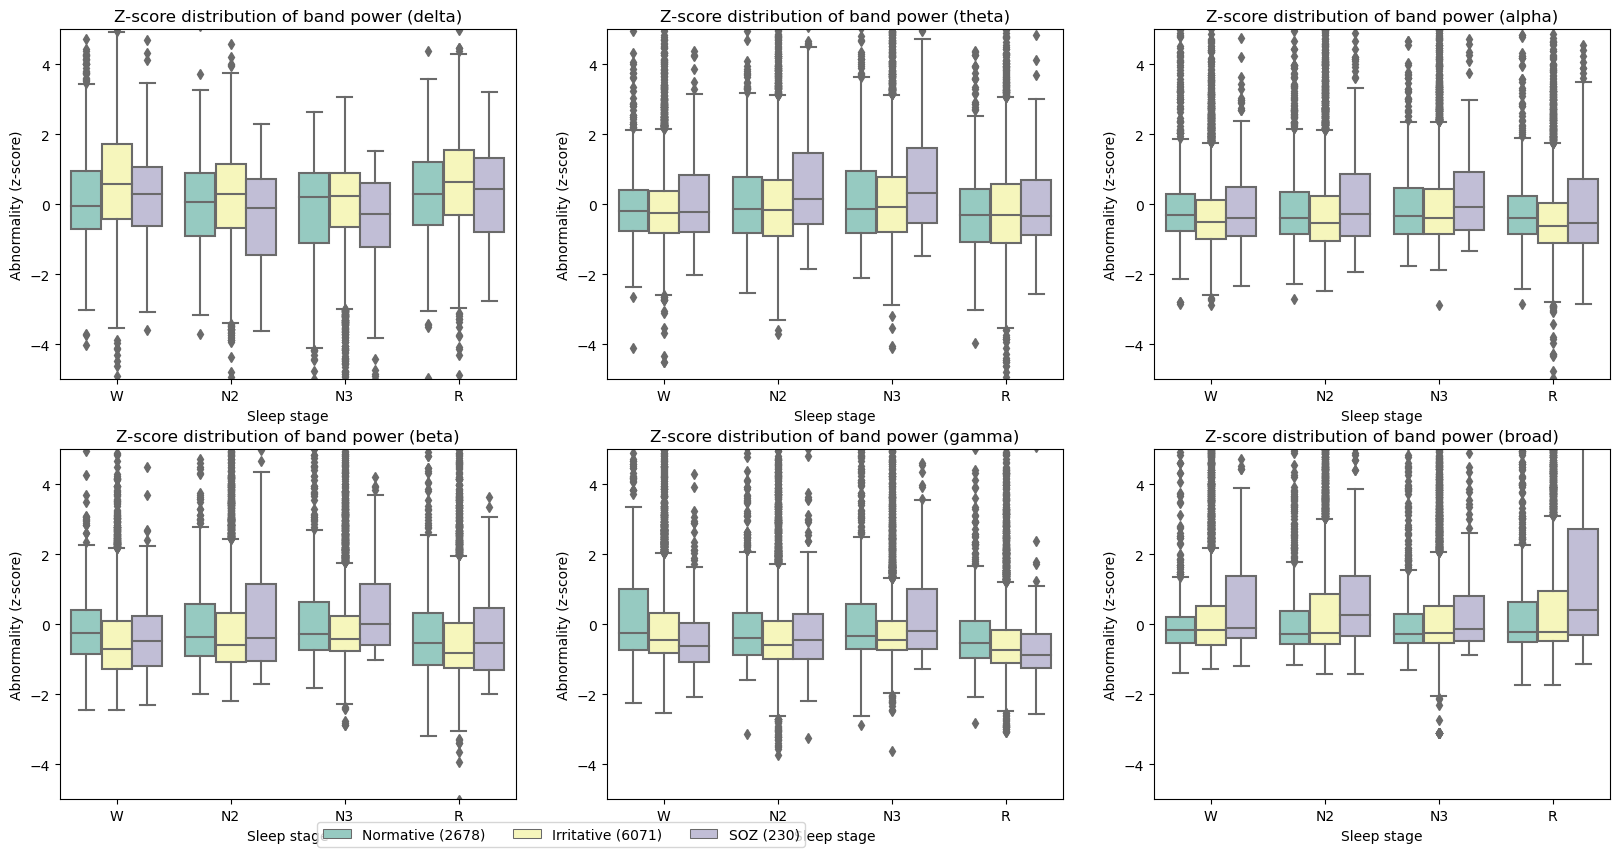

In [167]:
# plot grouped boxplot by sleep stage and frequency band
# 5 by 1 subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# for each frequency band plot grouped boxplot by sleep stage
for band_name in band_names:
    this_band_data = bp_melt.loc[bp_melt["band"] == band_name]
    ax = axs[band_names.index(band_name) // 3, band_names.index(band_name) % 3]
    sns.boxplot(x=this_band_data["stage"], y=this_band_data["z_score"], hue=this_band_data["type"], palette="Set3", showfliers=True, ax=ax)
    # do not show legend
    ax.get_legend().remove()
    # add significance stars
    ax.set_title(f"Z-score distribution of band power ({band_name})")
    ax.set_xlabel("Sleep stage")
    ax.set_ylabel("Abnormality (z-score)")
    ax.set_ylim(-5, 5)
# add legend to subplot
handles, _ = ax.get_legend_handles_labels()
labels = [f"Normative ({sum(metadata_df['normative'] == True)//4})", f"Irritative ({sum((metadata_df['normative'] == False) & (metadata_df['res_soz'] == False))//4})", f"SOZ ({sum((metadata_df['normative'] == False) & (metadata_df['res_soz'] == True))//4})"]
axs[1,1].legend(handles, labels,loc='center', bbox_to_anchor=(-0.1, -0.1), ncol=3)
plt.show()

In [199]:
# run multiple comparisons test for each frequency band and stage
for band_name in band_names:
    print("===========================================")
    for stage in sleep_stages_to_run:
        print(f"Band: {band_name}, Stage: {stage}")
        this_test_data = bp_melt.loc[(bp_melt["band"] == band_name) & (bp_melt["stage"] == stage)]
        # remove rows of this_test_data where z_score is nan or inf
        this_test_data = this_test_data.loc[~np.isnan(this_test_data["z_score"])]
        this_test_data = this_test_data.loc[~np.isinf(this_test_data["z_score"])]
        test_data = [this_test_data.loc[this_test_data["type"] == typ]["z_score"] for typ in ["normative", "irritative", "soz"]]
        stat, p = stats.f_oneway(*test_data)
        # if less than 0.05, print a star
        print(f"p-value: {p}", end="")
        if p < 0.05:
            print("*")
            # run tukey HSD
            mc = MultiComparison(this_test_data["z_score"], this_test_data["type"])
            result = mc.tukeyhsd()
            print(result)
        else:
            print("")


Band: delta, Stage: W
p-value: 4.7233783022022215e-20*
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2  meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
irritative normative  -0.4908    0.0 -0.6189 -0.3628   True
irritative       soz  -0.3708 0.0009 -0.6109 -0.1308   True
 normative       soz     0.12 0.5348 -0.1437  0.3838  False
-----------------------------------------------------------
Band: delta, Stage: N2
p-value: 7.811858175979857e-11*
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2  meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
irritative normative  -0.2357    0.0 -0.3579 -0.1134   True
irritative       soz  -0.5075    0.0 -0.7261 -0.2888   True
 normative       soz  -0.2718 0.0236 -0.5145  -0.029   True
-----------------------------------------------------------
Band: delta, Stage: N3
p-value: 5.683643344590264e

In [163]:
# repeat for coherence
co_scores_all = np.concatenate((co_scores["W"], co_scores["N2"], co_scores["N3"], co_scores["R"]))
co_scores_all_df = pd.DataFrame(co_scores_all, columns=band_names)
co_scores_all_df["stage"] = metadata_df["stage"]
co_scores_all_df["channel_num"] = range(1, co_scores_all_df.shape[0]+1)
co_scores_all_df["type"] = metadata_df["type"]
co_melt = co_scores_all_df.melt(id_vars=["stage", "channel_num", "type"], var_name="band", value_name="z_score")
# remove values where z_score = 0 and type = normative
#co_melt = co_melt.loc[~((co_melt["z_score"] == 0) & (co_melt["type"] == "normative"))]

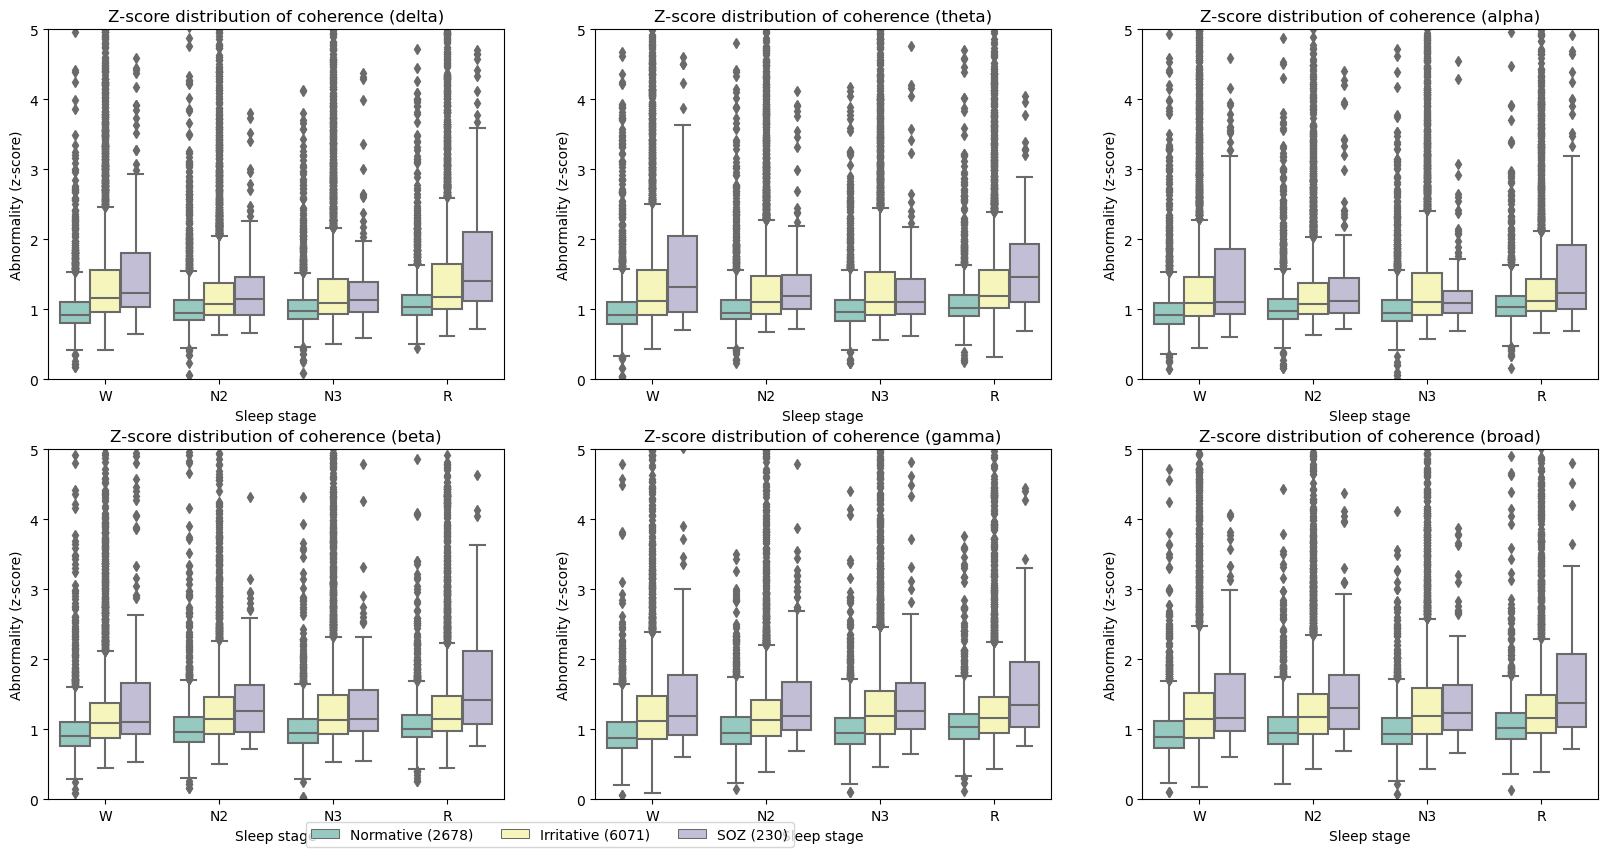

In [171]:
# plot grouped boxplot by sleep stage and frequency band
# 5 by 1 subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# for each frequency band plot grouped boxplot by sleep stage
for band_name in band_names:
    this_band_data = co_melt.loc[co_melt["band"] == band_name]
    ax = axs[band_names.index(band_name) // 3, band_names.index(band_name) % 3]
    sns.boxplot(x=this_band_data["stage"], y=this_band_data["z_score"], hue=this_band_data["type"], palette="Set3", showfliers=True, ax=ax)
    # do not show legend
    ax.get_legend().remove()
    # add significance stars
    ax.set_title(f"Z-score distribution of coherence ({band_name})")
    ax.set_xlabel("Sleep stage")
    ax.set_ylabel("Abnormality (z-score)")
    ax.set_ylim(0, 5)
# add legend to subplot
handles, _ = ax.get_legend_handles_labels()
labels = [f"Normative ({sum(metadata_df['normative'] == True)//4})", f"Irritative ({sum((metadata_df['normative'] == False) & (metadata_df['res_soz'] == False))//4})", f"SOZ ({sum((metadata_df['normative'] == False) & (metadata_df['res_soz'] == True))//4})"]
axs[1,1].legend(handles, labels,loc='center', bbox_to_anchor=(-0.1, -0.1), ncol=3)
plt.show()

In [201]:
# run multiple comparisons test for each frequency band and stage
for band_name in band_names:
    print("===========================================")
    for stage in sleep_stages_to_run:
        print(f"Band: {band_name}, Stage: {stage}")
        this_test_data = co_melt.loc[(co_melt["band"] == band_name) & (co_melt["stage"] == stage)]
        # remove rows of this_test_data where z_score is nan or inf
        this_test_data = this_test_data.loc[~np.isnan(this_test_data["z_score"])]
        this_test_data = this_test_data.loc[~np.isinf(this_test_data["z_score"])]
        test_data = [this_test_data.loc[this_test_data["type"] == typ]["z_score"] for typ in ["normative", "irritative", "soz"]]
        stat, p = stats.f_oneway(*test_data)
        # if less than 0.05, print a star
        print(f"p-value: {p}", end="")
        if p < 0.05:
            print("*")
            # run tukey HSD
            mc = MultiComparison(this_test_data["z_score"], this_test_data["type"])
            result = mc.tukeyhsd()
            print(result)
        else:
            print("")


Band: delta, Stage: W
p-value: 0.11256739610659673
Band: delta, Stage: N2
p-value: 3.72687159095425e-22*
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2  meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
irritative normative  -0.3872    0.0 -0.4855 -0.2889   True
irritative       soz   0.3324 0.0162  0.0496  0.6152   True
 normative       soz   0.7196    0.0  0.4302  1.0091   True
-----------------------------------------------------------
Band: delta, Stage: N3
p-value: 0.00018731037041531484*
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2  meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
irritative normative  -0.8627 0.0002 -1.3624 -0.3629   True
irritative       soz  -0.8403 0.3951 -2.3553  0.6748  False
 normative       soz   0.0224 0.9994 -1.5249  1.5696  False
-----------------------------------------------------------

In [224]:
# get indices of normative good outcome channels
normative_good_outcome_indices = np.where((metadata_csv["engel"] == 1) & (metadata_csv["normative"] == True))[0]
# get indices of res_soz channels
res_soz_indices = np.where(single_stage_metadata_df["res_soz"] == True)[0]
sample_indices = sorted(np.concatenate((normative_good_outcome_indices, res_soz_indices)))

>> Sleep stage: W
(1138, 6)
(1138, 12)
Fold 0:
Confusion matrix:
 [[92  0]
 [14  5]]
Fold 1:
Confusion matrix:
 [[70  5]
 [35  2]]
Fold 2:
Confusion matrix:
 [[107   4]
 [  0   0]]
Fold 3:
Confusion matrix:
 [[94  3]
 [12  3]]
Fold 4:
Confusion matrix:
 [[80  2]
 [17 12]]
Fold 5:
Confusion matrix:
 [[78  3]
 [19 11]]
Fold 6:
Confusion matrix:
 [[93  1]
 [14  3]]
Fold 7:
Confusion matrix:
 [[89  3]
 [14  6]]
Fold 8:
Confusion matrix:
 [[84 20]
 [ 6  0]]
Fold 9:
Confusion matrix:
 [[59  3]
 [40  8]]
Scores: [0.8738738738738738, 0.6428571428571429, 0.963963963963964, 0.8660714285714286, 0.8288288288288288, 0.8018018018018018, 0.8648648648648649, 0.8482142857142857, 0.7636363636363637, 0.6090909090909091]
Mean of scores: 0.8063203463203463

Results for testing model trained on good outcome patients on patients with no surgery: (stage = W)
Score on patients with no surgery: 0.8900599297375491
Confusion matrix: [[4259  235]
 [ 297   48]]


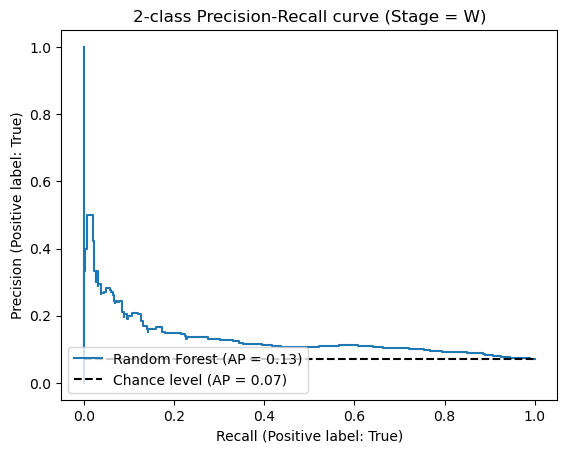

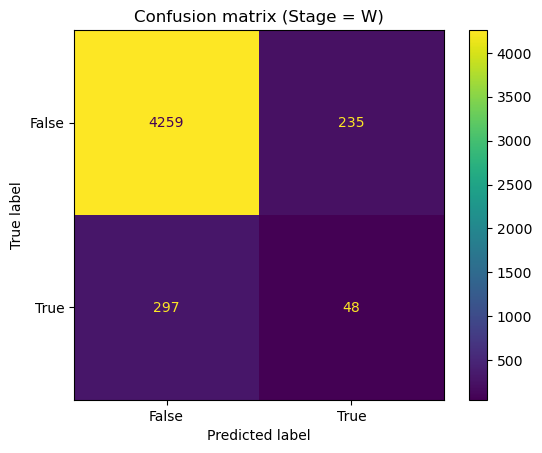

>> Sleep stage: N2
(1138, 6)
(1138, 12)
Fold 0:
Confusion matrix:
 [[84  2]
 [11  1]]
Fold 1:
Confusion matrix:
 [[73  3]
 [15  7]]
Fold 2:
Confusion matrix:
 [[78  4]
 [13  3]]
Fold 3:
Confusion matrix:
 [[81  6]
 [ 9  1]]
Fold 4:
Confusion matrix:
 [[75  7]
 [ 7  8]]
Fold 5:
Confusion matrix:
 [[84  0]
 [10  3]]
Fold 6:
Confusion matrix:
 [[75  1]
 [21  0]]
Fold 7:
Confusion matrix:
 [[64  0]
 [33  1]]
Fold 8:
Confusion matrix:
 [[78  4]
 [ 6  9]]
Fold 9:
Confusion matrix:
 [[55  4]
 [31  7]]
Scores: [0.8673469387755102, 0.8163265306122449, 0.826530612244898, 0.845360824742268, 0.8556701030927835, 0.8969072164948454, 0.7731958762886598, 0.6632653061224489, 0.8969072164948454, 0.6391752577319587]
Mean of scores: 0.8080685882600462

Results for testing model trained on good outcome patients on patients with no surgery: (stage = N2)
Score on patients with no surgery: 0.8826164874551972
Confusion matrix: [[3886  253]
 [ 271   54]]


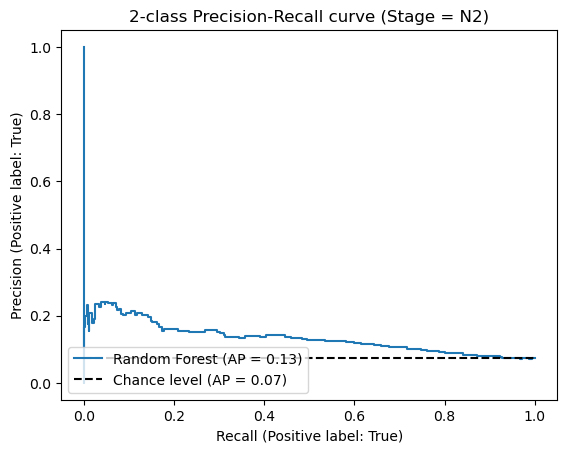

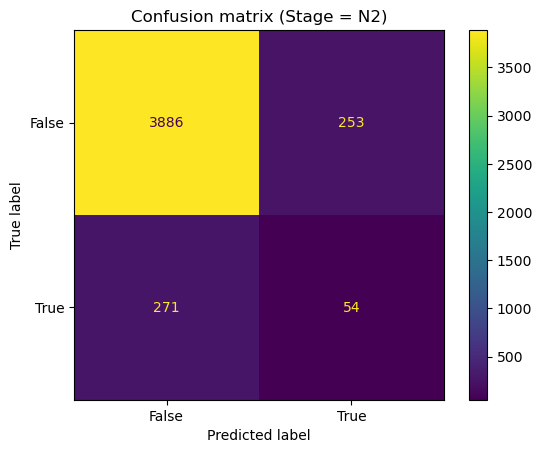

>> Sleep stage: N3
(1138, 6)
(1138, 12)
Fold 0:
Confusion matrix:
 [[60  0]
 [30  1]]
Fold 1:
Confusion matrix:
 [[82  3]
 [ 2  5]]
Fold 2:
Confusion matrix:
 [[76  3]
 [10  3]]
Fold 3:
Confusion matrix:
 [[68  2]
 [17  4]]
Fold 4:
Confusion matrix:
 [[72  0]
 [18  2]]
Fold 5:
Confusion matrix:
 [[75  0]
 [16  0]]
Fold 6:
Confusion matrix:
 [[71  0]
 [12  8]]
Fold 7:
Confusion matrix:
 [[82  4]
 [ 5  1]]
Fold 8:
Confusion matrix:
 [[55  5]
 [25  5]]
Fold 9:
Confusion matrix:
 [[76  6]
 [ 9  0]]
Scores: [0.6703296703296703, 0.9456521739130435, 0.8586956521739131, 0.7912087912087912, 0.8043478260869565, 0.8241758241758241, 0.8681318681318682, 0.9021739130434783, 0.6666666666666666, 0.8351648351648352]
Mean of scores: 0.8166547220895047

Results for testing model trained on good outcome patients on patients with no surgery: (stage = N3)
Score on patients with no surgery: 0.8654839434089378
Confusion matrix: [[3783  347]
 [ 252   71]]


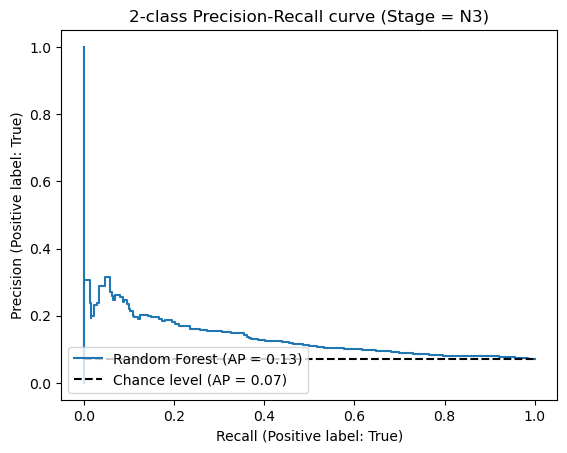

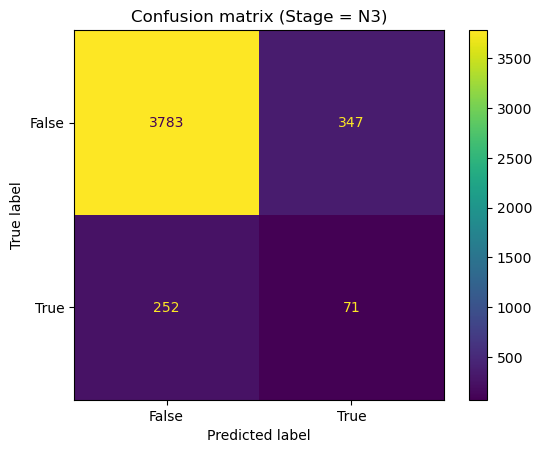

>> Sleep stage: R
(1138, 6)
(1138, 12)
Fold 0:
Confusion matrix:
 [[70  1]
 [11  3]]
Fold 1:
Confusion matrix:
 [[58  3]
 [16  8]]
Fold 2:
Confusion matrix:
 [[51  5]
 [21  9]]
Fold 3:
Confusion matrix:
 [[76  0]
 [ 5  3]]
Fold 4:
Confusion matrix:
 [[66  1]
 [12  6]]
Fold 5:
Confusion matrix:
 [[60  8]
 [11  5]]
Fold 6:
Confusion matrix:
 [[69  2]
 [ 9  4]]
Fold 7:
Confusion matrix:
 [[73  5]
 [ 6  0]]
Fold 8:
Confusion matrix:
 [[51  3]
 [21 10]]
Fold 9:
Confusion matrix:
 [[68  5]
 [ 6  5]]
Scores: [0.8588235294117647, 0.7764705882352941, 0.6976744186046512, 0.9404761904761905, 0.8470588235294118, 0.7738095238095238, 0.8690476190476191, 0.8690476190476191, 0.7176470588235294, 0.8690476190476191]
Mean of scores: 0.8219102990033222

Results for testing model trained on good outcome patients on patients with no surgery: (stage = R)
Score on patients with no surgery: 0.8410540915395285
Confusion matrix: [[2955  344]
 [ 229   77]]


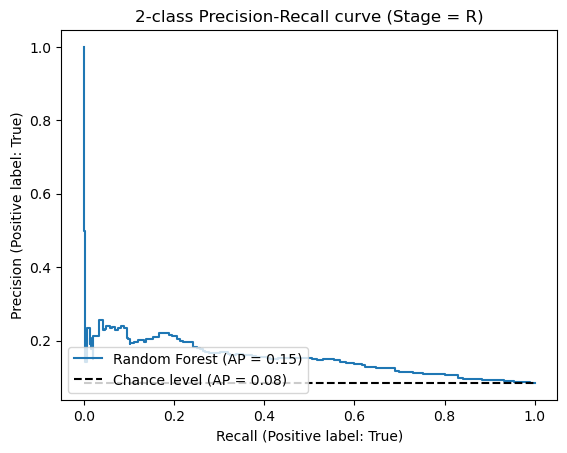

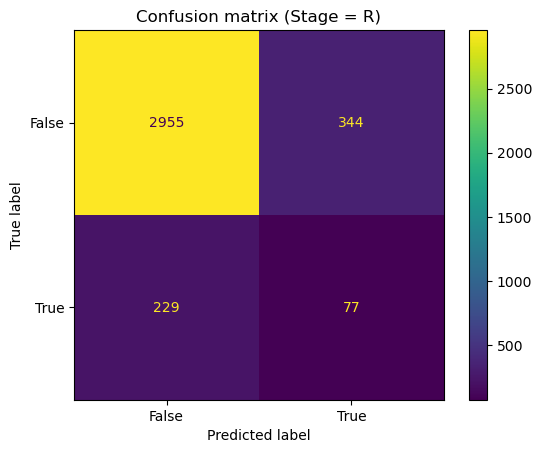

In [228]:
# for each sleep stage
for stage in sleep_stages_to_run:
    print(f">> Sleep stage: {stage}")

    this_bp_scores = bp_scores[stage]
    this_co_scores = co_scores[stage]

    X_train = []
    # get the rows of this_bp_scores for X_train
    X_train = np.array(this_bp_scores)[sample_indices,:]
    print(X_train.shape)
    # get the rows of this_co_scores for X_train
    X_train = np.concatenate((X_train, np.array(this_co_scores)[sample_indices]), axis=1)
    print(X_train.shape)

    groups = np.array(metadata_csv.iloc[sample_indices]["pt"])

    # get rows of patients with at least one True in Ch1_resected or Ch2_resected and at least one True in Ch1_soz or Ch2_soz
    y_train = np.array([(x in res_soz_indices) for x in sample_indices])

    # get rows in X_train that have at least one NaN or Inf or if there are 6 or more zeros in a row
    nan_indices = np.where(np.isnan(X_train).any(axis=1) | np.isinf(X_train).any(axis=1) | (np.sum(X_train == 0, axis=1) >= 6))[0]
    # remove rows with NaN
    X_train = np.delete(X_train, nan_indices, axis=0)
    y_train = np.delete(y_train, nan_indices)
    groups = np.delete(groups, nan_indices)

    # 10 fold validation
    cross_val_scores = []
    group_kfold = GroupKFold(n_splits=10)
    for i, (train_index, test_index) in enumerate(group_kfold.split(X_train, y_train, groups)):
        print(f"Fold {i}:")
        #print(f"  Train: index={train_index}, group={groups[train_index]}")
        #print(f"  Test:  index={test_index}, group={groups[test_index]}")

        rf = RandomForestClassifier()
        rf.fit(X_train[train_index,:], y_train[train_index.astype(int)])
        pred = rf.predict(X_train[test_index,:])
        cm = confusion_matrix(y_train[test_index], pred)
        print(f"Confusion matrix:\n {cm}")

        cross_val_scores.append(rf.score(X_train[test_index], y_train[test_index]))

    #scores = cross_val_score(rf, X_train, y_train, cv=10, error_score="raise")
    print(f"Scores: {cross_val_scores}")
    print(f"Mean of scores: {np.mean(cross_val_scores)}")

    # test on patients with no surgery
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # get indices of patients with nan in both resected columns
    no_surg_indices = np.where(pd.isnull(metadata_csv["ch1_resected"]) & pd.isnull(metadata_csv["ch2_resected"]))[0]

    X_no_surg_train = np.array(this_bp_scores)[no_surg_indices,:]
    X_no_surg_train = np.concatenate((X_no_surg_train, np.array(this_co_scores)[no_surg_indices]), axis=1)
    # 1 if at least one True in ch1_soz or ch2_soz
    y_no_surg_train = [int((row[1]["ch1_soz"] is True) | (row[1]["ch2_soz"] is True)) for row in metadata_csv.iloc[no_surg_indices].iterrows()]

    # get rows in X_train that have at least one Inf or NaN
    nan_indices = np.where(np.isnan(X_no_surg_train).any(axis=1) | np.isinf(X_no_surg_train).any(axis=1))[0]
    # remove rows with NaN
    X_no_surg_train = np.delete(X_no_surg_train, nan_indices, axis=0)
    y_no_surg_train = np.delete(y_no_surg_train, nan_indices)

    no_surg_score = rf.score(X_no_surg_train, y_no_surg_train)

    print(f"\nResults for testing model trained on good outcome patients on patients with no surgery: (stage = {stage})")

    print(f"Score on patients with no surgery: {no_surg_score}")

    display = PrecisionRecallDisplay.from_estimator(rf, X_no_surg_train, y_no_surg_train, name="Random Forest", plot_chance_level=True)
    _ = display.ax_.set_title(f"2-class Precision-Recall curve (Stage = {stage})")

    pred = rf.predict(X_no_surg_train)
    cm = confusion_matrix(y_no_surg_train, pred)
    print(f"Confusion matrix: {cm}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
    disp.plot()
    disp.ax_.set_title(f"Confusion matrix (Stage = {stage})")
    plt.show()

>> Sleep stage: W
(1138, 6)
Fold 0:
Confusion matrix:
 [[91  1]
 [17  4]]
Fold 1:
Confusion matrix:
 [[79  3]
 [29  1]]
Fold 2:
Confusion matrix:
 [[98  2]
 [ 3  9]]
Fold 3:
Confusion matrix:
 [[83  2]
 [12 14]]
Fold 4:
Confusion matrix:
 [[85  3]
 [23  1]]
Fold 5:
Confusion matrix:
 [[84 10]
 [17  0]]
Fold 6:
Confusion matrix:
 [[98  1]
 [12  0]]
Fold 7:
Confusion matrix:
 [[57 20]
 [28  6]]
Fold 8:
Confusion matrix:
 [[92  2]
 [13  5]]
Fold 9:
Confusion matrix:
 [[75  9]
 [23  5]]
Scores: [0.8407079646017699, 0.7142857142857143, 0.9553571428571429, 0.8738738738738738, 0.7678571428571429, 0.7567567567567568, 0.8828828828828829, 0.5675675675675675, 0.8660714285714286, 0.7142857142857143]
Mean of scores: 0.7939646188539994

Results for testing model trained on good outcome patients on patients with no surgery: (stage = W)
Score on patients with no surgery: 0.8729110790179493
Confusion matrix: [[4173  328]
 [ 288   58]]


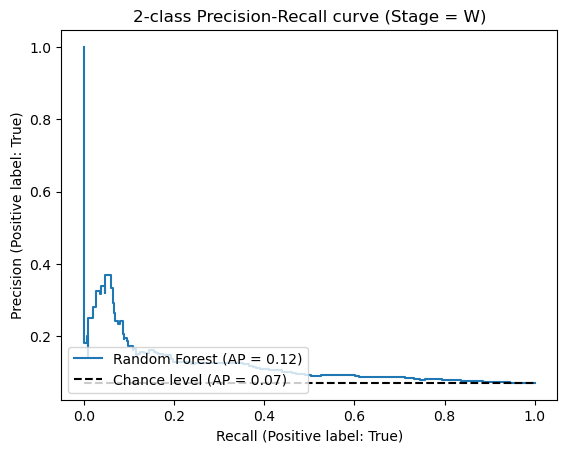

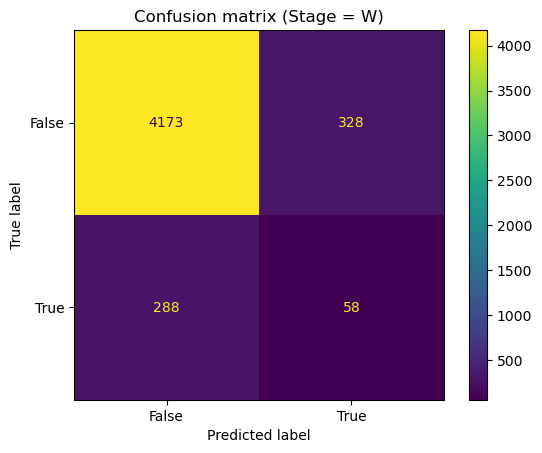

>> Sleep stage: N2
(1138, 6)
Fold 0:
Confusion matrix:
 [[83  3]
 [10  3]]
Fold 1:
Confusion matrix:
 [[71  5]
 [18  4]]
Fold 2:
Confusion matrix:
 [[79  3]
 [13  3]]
Fold 3:
Confusion matrix:
 [[83  4]
 [ 8  3]]
Fold 4:
Confusion matrix:
 [[71 11]
 [11  5]]
Fold 5:
Confusion matrix:
 [[81  3]
 [10  4]]
Fold 6:
Confusion matrix:
 [[70  6]
 [21  0]]
Fold 7:
Confusion matrix:
 [[77  2]
 [17  1]]
Fold 8:
Confusion matrix:
 [[76  0]
 [15  6]]
Fold 9:
Confusion matrix:
 [[49  4]
 [42  2]]
Scores: [0.8686868686868687, 0.7653061224489796, 0.8367346938775511, 0.8775510204081632, 0.7755102040816326, 0.8673469387755102, 0.7216494845360825, 0.8041237113402062, 0.845360824742268, 0.5257731958762887]
Mean of scores: 0.7888043064773551

Results for testing model trained on good outcome patients on patients with no surgery: (stage = N2)
Score on patients with no surgery: 0.8426464014304873
Confusion matrix: [[3707  439]
 [ 265   63]]


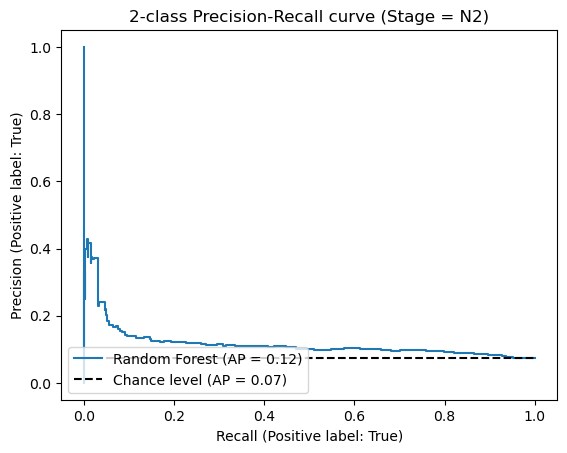

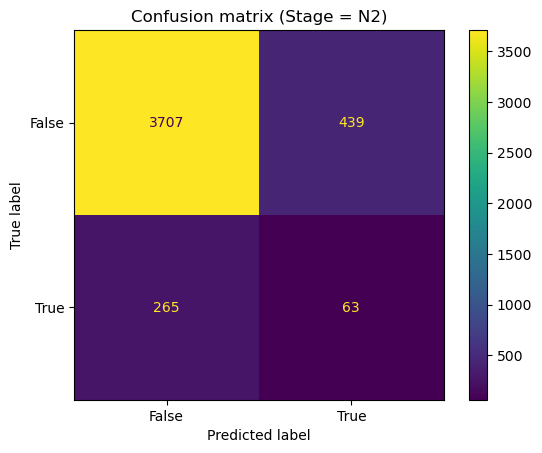

>> Sleep stage: N3
(1138, 6)
Fold 0:
Confusion matrix:
 [[60  0]
 [31  1]]
Fold 1:
Confusion matrix:
 [[80  6]
 [ 3  4]]
Fold 2:
Confusion matrix:
 [[75  0]
 [14  3]]
Fold 3:
Confusion matrix:
 [[68  7]
 [14  2]]
Fold 4:
Confusion matrix:
 [[75  4]
 [11  2]]
Fold 5:
Confusion matrix:
 [[72  1]
 [16  3]]
Fold 6:
Confusion matrix:
 [[70  2]
 [13  7]]
Fold 7:
Confusion matrix:
 [[73  8]
 [ 9  1]]
Fold 8:
Confusion matrix:
 [[64  4]
 [22  2]]
Fold 9:
Confusion matrix:
 [[74  2]
 [13  2]]
Scores: [0.6630434782608695, 0.9032258064516129, 0.8478260869565217, 0.7692307692307693, 0.8369565217391305, 0.8152173913043478, 0.8369565217391305, 0.8131868131868132, 0.717391304347826, 0.8351648351648352]
Mean of scores: 0.8038199528381857

Results for testing model trained on good outcome patients on patients with no surgery: (stage = N3)
Score on patients with no surgery: 0.8221973094170404
Confusion matrix: [[3575  559]
 [ 234   92]]


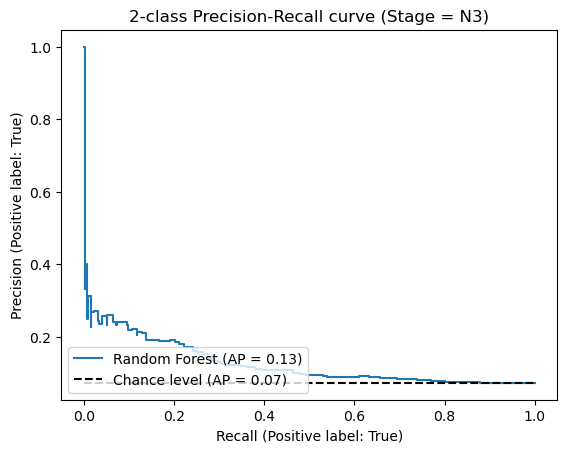

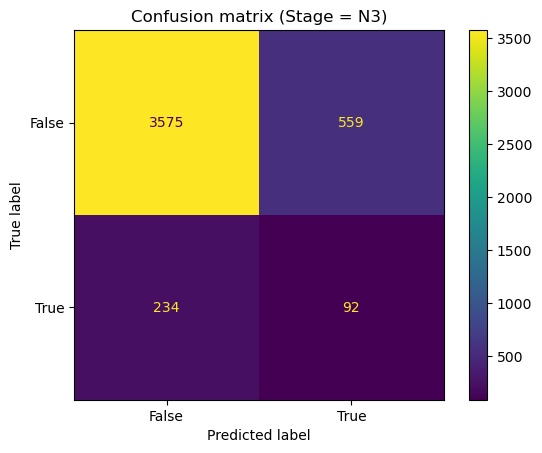

>> Sleep stage: R
(1138, 6)
Fold 0:
Confusion matrix:
 [[75  1]
 [10  0]]
Fold 1:
Confusion matrix:
 [[61  3]
 [15  7]]
Fold 2:
Confusion matrix:
 [[54  2]
 [25  6]]
Fold 3:
Confusion matrix:
 [[75  1]
 [10  0]]
Fold 4:
Confusion matrix:
 [[65  2]
 [ 9 11]]
Fold 5:
Confusion matrix:
 [[66  5]
 [13  2]]
Fold 6:
Confusion matrix:
 [[68  1]
 [ 9  8]]
Fold 7:
Confusion matrix:
 [[74  4]
 [ 8  0]]
Fold 8:
Confusion matrix:
 [[48  5]
 [19 13]]
Fold 9:
Confusion matrix:
 [[62  9]
 [12  2]]
Scores: [0.872093023255814, 0.7906976744186046, 0.6896551724137931, 0.872093023255814, 0.8735632183908046, 0.7906976744186046, 0.8837209302325582, 0.8604651162790697, 0.7176470588235294, 0.7529411764705882]
Mean of scores: 0.810357406795918

Results for testing model trained on good outcome patients on patients with no surgery: (stage = R)
Score on patients with no surgery: 0.8146516111264115
Confusion matrix: [[2853  463]
 [ 210  105]]


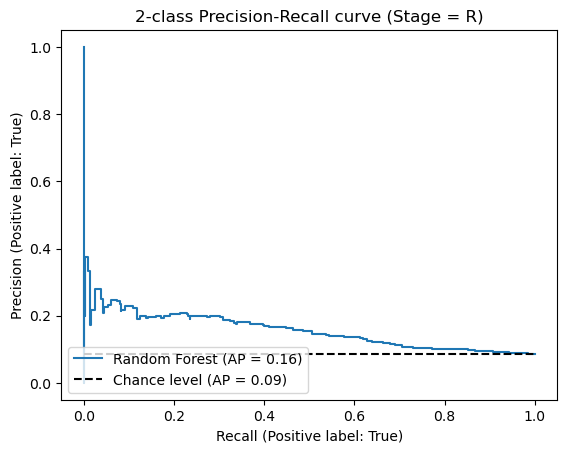

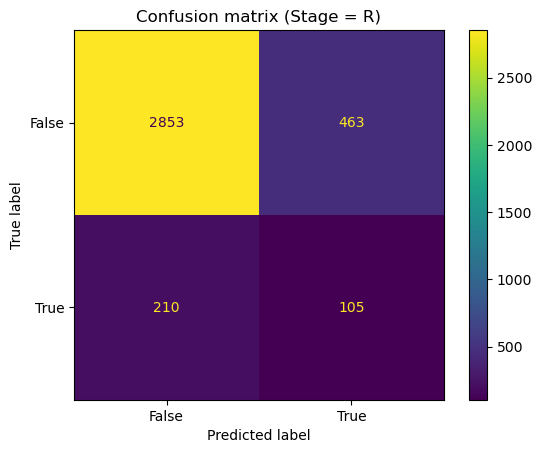

In [230]:
# for each sleep stage
for stage in sleep_stages_to_run:
    print(f">> Sleep stage: {stage}")

    this_bp_scores = bp_scores[stage]
    this_co_scores = co_scores[stage]

    X_train = []
    # get the rows of this_bp_scores for X_train
    X_train = np.array(this_co_scores)[sample_indices,:]
    print(X_train.shape)
    # get the rows of this_co_scores for X_train
    #X_train = np.concatenate((X_train, np.array(this_co_scores)[sample_indices]), axis=1)
    #print(X_train.shape)

    groups = np.array(metadata_csv.iloc[sample_indices]["pt"])

    # get rows of patients with at least one True in Ch1_resected or Ch2_resected and at least one True in Ch1_soz or Ch2_soz
    y_train = np.array([(x in res_soz_indices) for x in sample_indices])

    # get rows in X_train that have at least one NaN or Inf or if there are 6 or more zeros in a row
    nan_indices = np.where(np.isnan(X_train).any(axis=1) | np.isinf(X_train).any(axis=1) | (np.sum(X_train == 0, axis=1) >= 6))[0]
    # remove rows with NaN
    X_train = np.delete(X_train, nan_indices, axis=0)
    y_train = np.delete(y_train, nan_indices)
    groups = np.delete(groups, nan_indices)

    # 10 fold validation
    cross_val_scores = []
    group_kfold = GroupKFold(n_splits=10)
    for i, (train_index, test_index) in enumerate(group_kfold.split(X_train, y_train, groups)):
        print(f"Fold {i}:")
        #print(f"  Train: index={train_index}, group={groups[train_index]}")
        #print(f"  Test:  index={test_index}, group={groups[test_index]}")

        rf = RandomForestClassifier()
        rf.fit(X_train[train_index,:], y_train[train_index.astype(int)])
        pred = rf.predict(X_train[test_index,:])
        cm = confusion_matrix(y_train[test_index], pred)
        print(f"Confusion matrix:\n {cm}")

        cross_val_scores.append(rf.score(X_train[test_index], y_train[test_index]))

    #scores = cross_val_score(rf, X_train, y_train, cv=10, error_score="raise")
    print(f"Scores: {cross_val_scores}")
    print(f"Mean of scores: {np.mean(cross_val_scores)}")

    # test on patients with no surgery
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # get indices of patients with nan in both resected columns
    no_surg_indices = np.where(pd.isnull(metadata_csv["ch1_resected"]) & pd.isnull(metadata_csv["ch2_resected"]))[0]

    X_no_surg_train = np.array(this_co_scores)[no_surg_indices,:]
    #X_no_surg_train = np.concatenate((X_no_surg_train, np.array(this_co_scores)[no_surg_indices]), axis=1)
    # 1 if at least one True in ch1_soz or ch2_soz
    y_no_surg_train = [int((row[1]["ch1_soz"] is True) | (row[1]["ch2_soz"] is True)) for row in metadata_csv.iloc[no_surg_indices].iterrows()]

    # get rows in X_train that have at least one Inf or NaN
    nan_indices = np.where(np.isnan(X_no_surg_train).any(axis=1) | np.isinf(X_no_surg_train).any(axis=1))[0]
    # remove rows with NaN
    X_no_surg_train = np.delete(X_no_surg_train, nan_indices, axis=0)
    y_no_surg_train = np.delete(y_no_surg_train, nan_indices)

    no_surg_score = rf.score(X_no_surg_train, y_no_surg_train)

    print(f"\nResults for testing model trained on good outcome patients on patients with no surgery: (stage = {stage})")

    print(f"Score on patients with no surgery: {no_surg_score}")

    display = PrecisionRecallDisplay.from_estimator(rf, X_no_surg_train, y_no_surg_train, name="Random Forest", plot_chance_level=True)
    _ = display.ax_.set_title(f"2-class Precision-Recall curve (Stage = {stage})")

    pred = rf.predict(X_no_surg_train)
    cm = confusion_matrix(y_no_surg_train, pred)
    print(f"Confusion matrix: {cm}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
    disp.plot()
    disp.ax_.set_title(f"Confusion matrix (Stage = {stage})")
    plt.show()

(2984, 24)
(2984, 48)
Fold 0:
Confusion matrix:
 [[196]]
Fold 1:
Confusion matrix:
 [[200   0]
 [  3   0]]
Fold 2:
Confusion matrix:
 [[185   0]
 [ 20   0]]
Fold 3:
Confusion matrix:
 [[197   0]
 [ 11   0]]
Fold 4:
Confusion matrix:
 [[188   0]
 [  4   0]]
Fold 5:
Confusion matrix:
 [[188   0]
 [ 14   0]]
Fold 6:
Confusion matrix:
 [[176   1]
 [ 22   0]]
Fold 7:
Confusion matrix:
 [[179   0]
 [ 12   0]]
Fold 8:
Confusion matrix:
 [[185   1]
 [ 10   0]]
Fold 9:
Confusion matrix:
 [[195   0]
 [  6   0]]
Scores: [1.0, 0.9852216748768473, 0.9024390243902439, 0.9471153846153846, 0.9791666666666666, 0.9306930693069307, 0.8844221105527639, 0.93717277486911, 0.9438775510204082, 0.9701492537313433]
Mean of scores: 0.9480257510029698

Results for testing model trained on good outcome patients on patients with no surgery:
Score on patients with no surgery: 0.9182034503271862


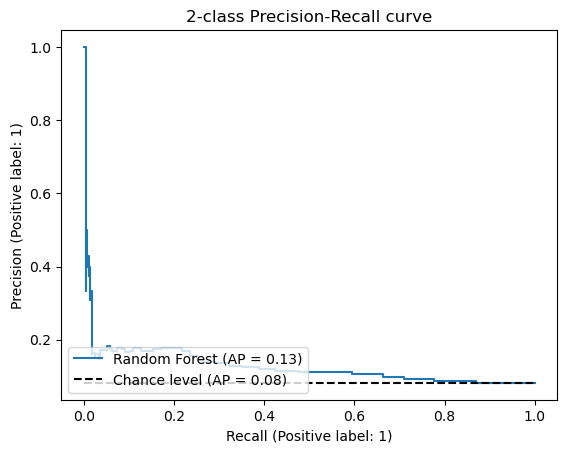

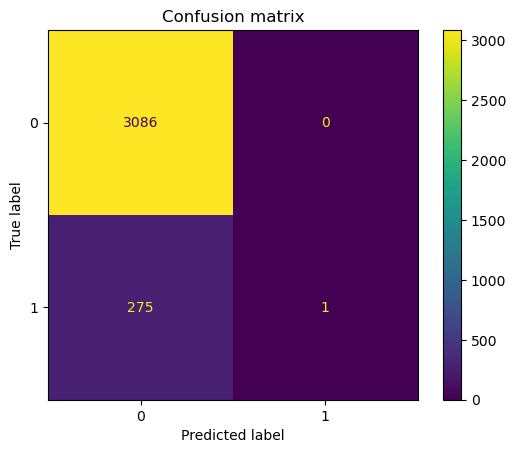

In [10]:
this_bp_scores = np.concatenate([bp_scores[stage] for stage in sleep_stages_to_run], axis=1)
this_co_scores = np.concatenate([co_scores[stage] for stage in sleep_stages_to_run], axis=1)

X_train = []
# get the rows of this_bp_scores for X_train
X_train = np.array(this_bp_scores)[good_outcome_indices,:]
print(X_train.shape)
# get the rows of this_co_scores for X_train
X_train = np.concatenate((X_train, np.array(this_co_scores)[good_outcome_indices]), axis=1)
print(X_train.shape)

groups = np.array(good_outcome_rows["pt"])

# get rows of patients with at least one True in Ch1_resected or Ch2_resected and at least one True in Ch1_soz or Ch2_soz
y_train = np.array([int(((row[1]["ch1_resected"] is True) | (row[1]["ch2_resected"] is True)) & ((row[1]["ch1_soz"] is True) | (row[1]["ch2_soz"] is True))) for row in good_outcome_rows.iterrows()])

# get rows in X_train that have at least one NaN or Inf
nan_indices = np.where(np.isnan(X_train).any(axis=1) | np.isinf(X_train).any(axis=1))[0]
# remove rows with NaN
X_train = np.delete(X_train, nan_indices, axis=0)
y_train = np.delete(y_train, nan_indices)    
groups = np.delete(groups, nan_indices)

# 10 fold validation
cross_val_scores = []
group_kfold = GroupKFold(n_splits=10)
for i, (train_index, test_index) in enumerate(group_kfold.split(X_train, y_train, groups)):
    print(f"Fold {i}:")
    #print(f"  Train: index={train_index}, group={groups[train_index]}")
    #print(f"  Test:  index={test_index}, group={groups[test_index]}")

    rf = RandomForestClassifier()
    rf.fit(X_train[train_index,:], y_train[train_index.astype(int)])
    pred = rf.predict(X_train[test_index,:])
    cm = confusion_matrix(y_train[test_index], pred)
    print(f"Confusion matrix:\n {cm}")

    cross_val_scores.append(rf.score(X_train[test_index], y_train[test_index]))

#scores = cross_val_score(rf, X_train, y_train, cv=10, error_score="raise")
print(f"Scores: {cross_val_scores}")
print(f"Mean of scores: {np.mean(cross_val_scores)}")

# test on patients with no surgery
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# get indices of patients with nan in both resected columns
no_surg_indices = np.where(pd.isnull(metadata_csv["ch1_resected"]) & pd.isnull(metadata_csv["ch2_resected"]))[0]

X_no_surg_train = np.array(this_bp_scores)[no_surg_indices,:]
X_no_surg_train = np.concatenate((X_no_surg_train, np.array(this_co_scores)[no_surg_indices]), axis=1)
# 1 if at least one True in ch1_soz or ch2_soz
y_no_surg_train = [int((row[1]["ch1_soz"] is True) | (row[1]["ch2_soz"] is True)) for row in metadata_csv.iloc[no_surg_indices].iterrows()]

# get rows in X_train that have at least one Inf or NaN
nan_indices = np.where(np.isnan(X_no_surg_train).any(axis=1) | np.isinf(X_no_surg_train).any(axis=1))[0]
# remove rows with NaN
X_no_surg_train = np.delete(X_no_surg_train, nan_indices, axis=0)
y_no_surg_train = np.delete(y_no_surg_train, nan_indices)

no_surg_score = rf.score(X_no_surg_train, y_no_surg_train)

print(f"\nResults for testing model trained on good outcome patients on patients with no surgery:")

print(f"Score on patients with no surgery: {no_surg_score}")

display = PrecisionRecallDisplay.from_estimator(rf, X_no_surg_train, y_no_surg_train, name="Random Forest", plot_chance_level=True)
_ = display.ax_.set_title(f"2-class Precision-Recall curve")

pred = rf.predict(X_no_surg_train)
cm = confusion_matrix(y_no_surg_train, pred)
#print(f"Confusion matrix: {cm}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
disp.ax_.set_title(f"Confusion matrix")
plt.show()